In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
import constants as c

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
synthfirm_all = read_csv('outputs/synthetic_firms.csv')
sf_map = gpd.read_file('inputs/Austin_freight.geojson')
mesozone_id_lookup = read_csv('inputs/zonal_id_lookup_final.csv')
sf_map.head(5)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEOID,CBPZONE,MESOZONE,geometry
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137..."
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ..."
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004..."
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ..."
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ..."


In [3]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE'])[['BusID']].count()
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count']
firm_by_zone.head(5)

Index(['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')


,MESOZONE,firm_count
0,1,43
1,2,32
2,3,27
3,4,30
4,5,37


In [4]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,43,6796,480019501001,48001,489,Rest of TX
1,2,32,3452,480019501002,48001,489,Rest of TX
2,3,27,2359,480019501003,48001,489,Rest of TX
3,4,30,3732,480019504011,48001,489,Rest of TX
4,5,37,3068,480019504021,48001,489,Rest of TX


In [9]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481, 488, 489])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

329362
4879053.363700018
417
409


In [10]:
firm_in_austin = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481])]
sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
sf_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,firm_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME
0,484530013052,48453,5676.0,"MULTIPOLYGON (((-97.76898 30.24602, -97.76484 ...",86,6,484530013052,48453,481,Austin
1,484910213004,48491,6730.0,"MULTIPOLYGON (((-97.55494 30.73420, -97.55005 ...",57,18,484910213004,48491,481,Austin
2,484530017384,48453,5773.0,"MULTIPOLYGON (((-97.87594 30.21458, -97.87348 ...",86,20,484530017384,48453,481,Austin
3,484530018481,48453,5947.0,"MULTIPOLYGON (((-97.70157 30.42772, -97.70006 ...",97,49,484530018481,48453,481,Austin
4,482090103044,48209,3129.0,"MULTIPOLYGON (((-97.92493 29.89346, -97.92389 ...",66,81,482090103044,48209,481,Austin


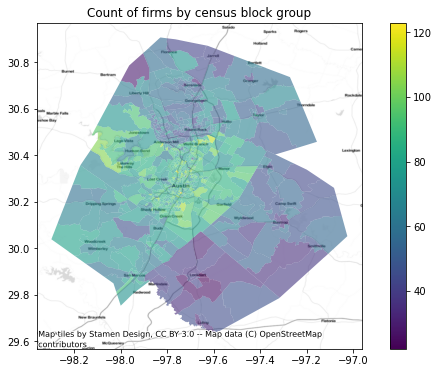

In [6]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'firm_count', alpha = 0.6, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Count of firms by census block group')
plt.savefig('plots/austin_firm_count.png', dpi = 200)

In [24]:
combined_modeled_OD = None

for sctg in c.list_of_sctg_group:
    print(sctg)
    b2b_dir = c.output_dir + sctg
    list_of_b2b_files = os.listdir(b2b_dir)
    iterator = 0
#     cut_off_point = max_ton_lookup[sctg] # shipment capacity for this shipment
    for file in list_of_b2b_files:
        if file == '.DS_Store':
            continue
        if iterator%10 == 0:
            print(iterator)
        modeled_OD_by_sctg = read_csv(b2b_dir + '/' + file, sep = ',', low_memory = False)
        modeled_OD_by_sctg['ShipmentLoad'] = modeled_OD_by_sctg['TruckLoad'] / 1000 # convert to thousand tons
        
        #print(cut_off_point)
#         modeled_OD_by_sctg.loc[modeled_OD_by_sctg['ShipmentLoad'] > cut_off_point, 'ShipmentLoad'] = cut_off_point
        modeled_OD_by_sctg['tmiles'] = modeled_OD_by_sctg['ShipmentLoad'] * 1000 * modeled_OD_by_sctg['Distance']
        modeled_OD_by_sctg = pd.merge(modeled_OD_by_sctg, mesozone_id_lookup, 
                                      left_on = ['SellerZone', 'orig_FAFID'], 
                                    right_on = ['MESOZONE', 'FAFID'], how = 'left')
        modeled_OD_by_sctg = modeled_OD_by_sctg.rename(columns={"GEOID": "orig_GEOID",
                                                                "CBPZONE": "orig_CBPZONE", 
                                                                "MESOZONE":"orig_MESOZONE", 
                                                                "FAFNAME":"orig_FAFNAME"})
        modeled_OD_by_sctg = pd.merge(modeled_OD_by_sctg, mesozone_id_lookup, 
                                      left_on = ['BuyerZone', 'dest_FAFID'], 
                                    right_on = ['MESOZONE', 'FAFID'], how = 'left')
        modeled_OD_by_sctg = modeled_OD_by_sctg.rename(columns={"GEOID": "dest_GEOID", 
                                                                "CBPZONE": "dest_CBPZONE", 
                                                                "MESOZONE":"dest_MESOZONE", 
                                                               "FAFNAME":"dest_FAFNAME"})    
        agg_OD_by_sctg = modeled_OD_by_sctg.groupby(["orig_FAFID", "orig_MESOZONE", "dest_FAFID", "dest_MESOZONE"])[['tmiles', 'ShipmentLoad']].sum()        
        agg_OD_by_sctg = agg_OD_by_sctg.reset_index()
        agg_count_by_sctg = modeled_OD_by_sctg.groupby(["orig_FAFID", "orig_MESOZONE", "dest_FAFID", "dest_MESOZONE"])[['shipment_id']].count() 
        agg_count_by_sctg = agg_count_by_sctg.reset_index()
        agg_OD_by_sctg = pd.merge(agg_OD_by_sctg, agg_count_by_sctg, 
                                  on = ["orig_FAFID", "orig_MESOZONE", "dest_FAFID", "dest_MESOZONE"],
                                  how = 'left')
        agg_OD_by_sctg = agg_OD_by_sctg.rename(columns={"shipment_id": "count"})
        agg_OD_by_sctg.loc[:, 'SCTG_Name'] = c.sctg_def[sctg]
        agg_OD_by_sctg.loc[:, 'chunk_id'] = iterator
        combined_modeled_OD = pd.concat([combined_modeled_OD, agg_OD_by_sctg], sort = False)
        iterator += 1 
#         break        
#     break
#     combined_truck_output.to_csv(c.input_dir + 'truck_only_OD_' + sctg + '.csv', index = False)
# combined_modeled_OD = pd.merge(combined_modeled_OD, sctg_group_definition, on = ['SCTG_Group'], how = 'left')
combined_modeled_OD.head(10)  

sctg1
0
10
sctg2
0
sctg3
0
10
20
30
sctg4
0
10
20
30
40
sctg5
0
10


,orig_FAFID,orig_MESOZONE,dest_FAFID,dest_MESOZONE,tmiles,ShipmentLoad,count,SCTG_Name,chunk_id
0,11,20001,64,4,68045.248008,0.027102,2,bulk,0
1,11,20001,64,5,27442.412632,0.013772,1,bulk,0
2,11,20001,64,6,3153.326894,0.001582,1,bulk,0
3,11,20001,64,7,19422.102522,0.009747,1,bulk,0
4,11,20001,64,8,28670.441800,0.010665,1,bulk,0
5,11,20001,64,12,2003.583060,0.001006,1,bulk,0
6,11,20001,64,13,57121.545289,0.028666,1,bulk,0
7,11,20001,64,14,35622.644200,0.013251,1,bulk,0
8,11,20001,64,15,60031.972000,0.022330,1,bulk,0
9,11,20001,64,16,188202.895556,0.080411,2,bulk,0


In [25]:
sf_origin_shipment = combined_modeled_OD.loc[combined_modeled_OD['orig_FAFID'] == 64]
sf_origin_shipment = sf_origin_shipment.groupby(['orig_MESOZONE'])[['ShipmentLoad']].sum()
sf_origin_shipment = sf_origin_shipment.reset_index()
sf_origin_shipment.columns = ['MESOZONE', 'Tonnage']
sf_origin_shipment.head(5)

,MESOZONE,Tonnage
0,1,9.011370
1,2,11.880804
2,3,1.192125
3,4,9.285994
4,5,6.660419


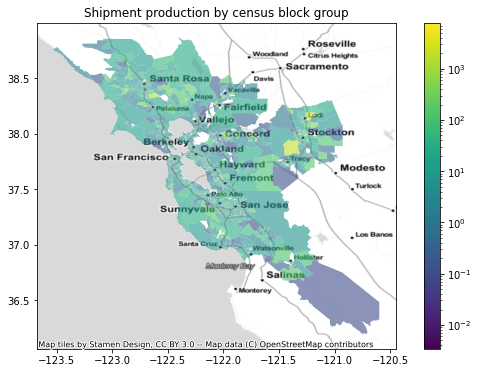

In [29]:
import matplotlib
sf_map_with_tonnage = sf_map.merge(sf_origin_shipment, on='MESOZONE', how='inner')
# sf_map_with_tonnage.head(5)
ax = sf_map_with_tonnage.plot(figsize = (10,6), column = 'Tonnage', alpha = 0.6, 
                               norm=matplotlib.colors.LogNorm(vmin=sf_map_with_tonnage.Tonnage.min(), vmax=sf_map_with_tonnage.Tonnage.max()),
                              legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Shipment production by census block group')
plt.savefig('Plot/sf_shipment_production.png', dpi = 200)
plt.show()